<a href="https://colab.research.google.com/github/SPThole/Sidhant_Thole/blob/master/text_classification_pytorch_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#installing the transformers 
!pip install transformers

In [38]:
#importing libraries which we might need
import pandas as pd
import numpy as np
import torch
import transformers
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torchtext
import zipfile
import os
from transformers import BertTokenizer as BT
from sklearn.model_selection import train_test_split
import warnings
import torch.nn as nn
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline

In [39]:
#Check if we have the cuda device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [40]:
#Getting the data out and taking a look at it
data = pd.read_csv('/content/drive/My Drive/reviews.csv')

In [41]:
data.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOH9y0mrXUuqulfB_d48QIXYJet79OMMr8jzm85...,John Oswald-Jacobs,https://play-lh.googleusercontent.com/-jB1fuDT...,Hopeless customer service. I paid for the prem...,1,46,5.6.0.1,2020-09-26 07:30:52,Sorry for the delay in reply! Due to adjusted ...,2020-09-27 10:50:27,most_relevant,com.anydo
1,gp:AOqpTOHNHm4OfbjkxEXXa51JwZEHAaDlvfSgN0OU256...,Lex S,https://play-lh.googleusercontent.com/-FgDpDeE...,"I love this app, but I do have one major gripe...",1,124,5.2.0.23,2020-08-05 16:22:04,"We ensured that Any.do would be fairly priced,...",2020-08-10 07:41:21,most_relevant,com.anydo


In [42]:
#Getting columns out which are important for sentiment analysis
data = data[['content','score']]

In [43]:
#Binning the data to get in total three scores (lower: negative , middle: Neutral (ok ok), higher: Positive)
bins = [0.,2.,3.,5.]
labels = [0,1,2]
data['sentiment'] = pd.cut(data['score'], bins=bins, labels=labels)

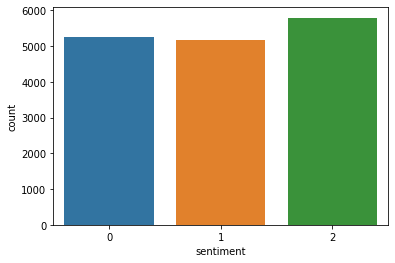

In [44]:
import seaborn as sns
sns.countplot(data['sentiment'])

In [45]:
#Lets play around the tokenizer
text = 'well, I just like that anyway'

In [46]:
#Getting out the pretrained tokenizer for our model
tokenizer_name = 'bert-base-uncased'
tokenizer = BT.from_pretrained(tokenizer_name)

In [47]:
#lets see how it tokenize the data
tokens_txt = tokenizer.tokenize(text)
print(f'tokens are {tokens_txt}')
tokens_ids = tokenizer.convert_tokens_to_ids(tokens_txt)
print(f'ids for above tokens are {tokens_ids}')

tokens are ['well', ',', 'i', 'just', 'like', 'that', 'anyway']
ids for above tokens are [2092, 1010, 1045, 2074, 2066, 2008, 4312]


In [48]:
# Encode plus do all above thing (tokenization ,getting ids , mask, padding) for us 
encoding = tokenizer.encode_plus(
    text = text,
    max_length = 30,
    truncation = True,
    add_special_tokens = True,
    pad_to_max_length = True,
    return_attention_mask=True,
    return_tensors ='pt'
)

In [49]:
# encodings are dictionary
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

In [50]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [51]:

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'well',
 ',',
 'i',
 'just',
 'like',
 'that',
 'anyway',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [52]:
torch.tensor([[2,3],[4,5]]).flatten()

tensor([2, 3, 4, 5])

In [53]:
class SentimentalData(Dataset):
  def __init__(self, text_reviews, labels, max_len, tokenizer):
    self.text = text_reviews
    self.labels = labels
    self.max_len = max_len
    self.tokenizer = tokenizer

  def __getitem__(self,idx):

    text = self.text[idx]
    labels = self.labels[idx]

    encoder = self.tokenizer.encode_plus(
        text = text,
        truncation =True,
        max_length = self.max_len,
        add_special_tokens = True,
        pad_to_max_length = True,
        return_attention_mask=True,
        return_tensors ='pt'
        
    )

    result_dict = {
        'text': text,
        'token_to_ids':encoder['input_ids'].flatten(),
        'token_mask':encoder['attention_mask'].flatten(),
        'label': torch.tensor(labels,dtype=torch.long)
    }

    return result_dict

  def __len__(self):
    return len(self.text)




In [54]:
X = data['content'].iloc[:600].values
y = data['sentiment'].iloc[:600].values
SEED = 2019

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size =0.2, random_state = SEED)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size =0.2, random_state= SEED)



In [55]:
train_dataset = SentimentalData(X_train, y_train , 120, tokenizer)
val_dataset = SentimentalData(X_val, y_val , 120, tokenizer)
test_dataset = SentimentalData(X_test, y_test , 120, tokenizer)

In [56]:
train_loader = DataLoader(train_dataset, batch_size= 16)
val_loader = DataLoader(val_dataset, batch_size= 16)
test_loader = DataLoader(test_dataset, batch_size= 16)

In [57]:
X_train.shape, X_val.shape, X_test.shape

((480,), (96,), (24,))

In [61]:
next(iter(train_loader))['label']

tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0])

In [63]:
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [64]:
last_hidden, output = model(encoding['input_ids'],encoding['attention_mask'])

In [65]:
last_hidden.shape, output.shape

(torch.Size([1, 30, 768]), torch.Size([1, 768]))

In [66]:
class SentimentalModel(nn.Module):
  def __init__(self,pretrained_model,num_classes):
    super(SentimentalModel,self).__init__()
    self.pretrained_model = pretrained_model
    self.drop = nn.Dropout(p=0.3)
    self.tf_layer = nn.Linear(in_features = self.pretrained_model.config.hidden_size, out_features=num_classes)

  def forward(self,input_ids,token_mask):
    _, output = self.pretrained_model(
        input_ids = input_ids,
        attention_mask = token_mask,
    )
    output = self.drop(output)
    output = self.tf_layer(output)
    return output

    


In [67]:
sentimental_model = SentimentalModel(model,3).to(device)

In [68]:
loss_func = nn.CrossEntropyLoss().to(device)

In [69]:
optimizer = torch.optim.AdamW(sentimental_model.parameters(),lr=0.2e-5)

In [76]:
def sentimentaltrain(model,train_loader):
  model = model.train()
  loss = []
  accs = 0
  for i, result_dict in enumerate(train_loader):

    optimizer.zero_grad()
    
    token_ids = result_dict['token_to_ids'].to(device)

    token_mask = result_dict['token_mask'].to(device)

    labels = result_dict['label'].to(device)

    output = model(token_ids,token_mask)

    train_loss = loss_func(output, labels)

    train_loss.backward()

    optimizer.step()
    
    loss.append(train_loss.item())

    _,preds = torch.max(output,dim=1)

    accs = accs + torch.sum(labels==preds)
  print('------------------------------------------------\n')
  print(f'Accuracy:\t {accs.double()/X_train.shape[0]}')
  print(f'loss:\t {np.mean(loss)}')
  print('------------------------------------------------\n')


def model_eval(model,loader):
  model = model.eval()
  loss = []
  accs = 0
  for i, result_dict in enumerate(loader):
    
    token_ids = result_dict['token_to_ids'].to(device)

    token_mask = result_dict['token_mask'].to(device)

    labels = result_dict['label'].to(device)

    output = model(token_ids,token_mask)

    val_loss = loss_func(output, labels)

    loss.append(val_loss.item())

    _,preds = torch.max(output,dim=1)

    accs = accs + torch.sum(labels==preds)
  print('------------------------------------------------\n')
  print(f'Accuracy:\t {accs.double()/X_val.shape[0]}')
  print(f'loss:\t {np.mean(loss)}')
  print('------------------------------------------------\n')
  
def trainer(model,epochs,train_loader,val_loader):
  
  for epoch in tqdm(range(epochs)):

    print('---------------------------------------------\n')

    print(f'Training at epoch: {epoch}')

    sentimentaltrain(model,train_loader)

    print(f'Validation')

    model_eval(model,val_loader)




In [77]:
trainer(sentimental_model,10,train_loader,val_loader)

---------------------------------------------

Training at epoch: 0
------------------------------------------------

Accuracy:	 0.75
loss:	 0.5835366477568944
------------------------------------------------

Validation
------------------------------------------------

Accuracy:	 0.6770833333333333
loss:	 0.6436384121576945
------------------------------------------------

---------------------------------------------

Training at epoch: 1
------------------------------------------------

Accuracy:	 0.7875
loss:	 0.551038466890653
------------------------------------------------

Validation
------------------------------------------------

Accuracy:	 0.6666666666666666
loss:	 0.6356240461270014
------------------------------------------------

---------------------------------------------

Training at epoch: 2
------------------------------------------------

Accuracy:	 0.8020833333333334
loss:	 0.5235575209061305
------------------------------------------------

Validation
----------

In [ ]:
l